# NBA Game Predictor Model
### CMPE 257 Project
Authors: Kaushika Uppu, Miranda Billawala, Yun Ei Hlaing, Iris Cheung

## Imports

In [71]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

## NBA Game Data

First, we load in all of the NBA game data from the CSV file. Exact code for gathering data is in a separate file and use the nba_api file. Only games from the 1985-1986 season and afterward are loaded in as the seasons before that are missing a very significant portion of the game statistics' data. 

In [72]:
all_stats = pd.read_csv('all_game_stats.csv')
all_stats.head()

SEASON_ID     TEAM_ID TEAM_ABBREVIATION      TEAM_NAME   GAME_ID  \
0    21985.0  1610612737               ATL  Atlanta Hawks  28500933   
1    21985.0  1610612737               ATL  Atlanta Hawks  28500921   
2    21985.0  1610612737               ATL  Atlanta Hawks  28500908   
3    21985.0  1610612737               ATL  Atlanta Hawks  28500891   
4    21985.0  1610612737               ATL  Atlanta Hawks  28500884   

    GAME_DATE      MATCHUP WL    MIN  FGM  ...  AST_RANK  TOV_RANK  STL_RANK  \
0  1986-04-12  ATL vs. IND  W  240.0   38  ...       NaN       NaN       NaN   
1  1986-04-10  ATL vs. NJN  W  240.0   44  ...       NaN       NaN       NaN   
2  1986-04-08  ATL vs. CHI  W  240.0   52  ...       NaN       NaN       NaN   
3  1986-04-05    ATL @ CHI  L  240.0   40  ...       NaN       NaN       NaN   
4  1986-04-04    ATL @ WAS  L  265.0   54  ...       NaN       NaN       NaN   

   BLK_RANK  BLKA_RANK  PF_RANK  PFD_RANK  PTS_RANK  PLUS_MINUS_RANK  \
0       NaN        NaN      NaN       NaN       NaN              NaN   
1       NaN        NaN      NaN       NaN       NaN              NaN   
2       NaN        NaN      NaN       NaN       NaN              NaN   
3       NaN        NaN      NaN       NaN       NaN              NaN   
4       NaN        NaN      NaN       NaN       NaN              NaN   

   AVAILABLE_FLAG  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  

[5 rows x 59 columns]

In [73]:
all_stats.shape

(89542, 59)

## Data Cleaning and Pre-Processing

### Inputting Missing Values

As shown below, there are a number of rows with the `SEASON_YEAR` variable missing. Therefore, we will calculate the `SEASON_YEAR` based on the `GAME_DATE` variable and fill in those missing values.

In [74]:
all_stats['SEASON_YEAR'].isna().sum()

23370

In [75]:
for index, row in all_stats.iterrows():
    if pd.isna(all_stats.iloc[index]['SEASON_YEAR']):
        year_index = all_stats.iloc[index]['GAME_DATE'].find('-')
        year = all_stats.iloc[index]['GAME_DATE'][:year_index]
        month = all_stats.iloc[index]['GAME_DATE'][year_index+1:year_index+3]
        if int(month) >= 10:
            season = str(int(year)) + "-" + str(int(year)+1)[2:]
        else:
            season = str(int(year)-1) + "-" + str(int(year))[2:]
        all_stats.loc[index, 'SEASON_YEAR'] = season

In [76]:
len(all_stats[all_stats['SEASON_YEAR'].isna()])

0

Then, we convert the `SEASON_YEAR` variable into an integer variable of just the year that the season started (e.g., 1985 for '1985-86').

In [77]:
all_stats['SEASON_YEAR'] = all_stats['SEASON_YEAR'].str.split('-').str[0].astype(int)

A look at the new `SEASON_YEAR` column:

In [78]:
all_stats[['SEASON_YEAR']].sample(10)

SEASON_YEAR
51895         1997
64058         1992
547           1991
41761         2022
11441         1988
58693         2003
22146         2005
77208         2010
70612         1996
67800         2000

In [79]:
all_stats.isna().sum()

SEASON_ID            66172
TEAM_ID                  0
TEAM_ABBREVIATION        0
TEAM_NAME                0
GAME_ID                  0
GAME_DATE                0
MATCHUP                  0
WL                       0
MIN                      0
FGM                      0
FGA                      0
FG_PCT                   0
FG3M                     0
FG3A                     0
FG3_PCT                475
FTM                      0
FTA                      0
FT_PCT                   0
OREB                     0
DREB                     0
REB                      0
AST                      0
STL                      0
BLK                      0
TOV                      0
PF                       0
PTS                      0
PLUS_MINUS               0
VIDEO_AVAILABLE      66172
SEASON_YEAR              0
BLKA                 23370
PFD                  23370
GP_RANK              23370
W_RANK               23370
L_RANK               23370
W_PCT_RANK           23370
MIN_RANK             23370
F

As seen above, there are also 475 missing values in the `FG3_PCT` column. Taking a look at the `FG3A` column for the rows with missing values, we can see that they are all 0, hence why the `FG3_PCT` column has NaN values for these rows. Therefore, we filled the missing values with 0.

In [80]:
all_stats[all_stats['FG3_PCT'].isna()]['FG3A'].unique()

array([0])

In [81]:
missing_indicies = all_stats[all_stats['FG3_PCT'].isna()].index

In [82]:
for i in missing_indicies:
    all_stats.loc[i, 'FG3_PCT'] = 0

### Dropping Irrelevant Columns

There are a lot of other columns in the dataset that have a significant number of missing values. We will drop these columns, as most of them are also rankings for stats that are already in the dataset.

In [83]:
to_drop = ['SEASON_ID', 'GAME_ID', 'VIDEO_AVAILABLE', 'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK', 'FGA_RANK',
           'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK',
           'DREB_RANK', 'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK', 'PF_RANK', 'PFD_RANK',
           'PTS_RANK', 'PLUS_MINUS_RANK', 'AVAILABLE_FLAG', 'BLKA', 'PFD' ]

In [84]:
all_stats_cleaned = all_stats.drop(columns = to_drop)

In [85]:
all_stats_cleaned.head()

TEAM_ID TEAM_ABBREVIATION      TEAM_NAME   GAME_DATE      MATCHUP WL  \
0  1610612737               ATL  Atlanta Hawks  1986-04-12  ATL vs. IND  W   
1  1610612737               ATL  Atlanta Hawks  1986-04-10  ATL vs. NJN  W   
2  1610612737               ATL  Atlanta Hawks  1986-04-08  ATL vs. CHI  W   
3  1610612737               ATL  Atlanta Hawks  1986-04-05    ATL @ CHI  L   
4  1610612737               ATL  Atlanta Hawks  1986-04-04    ATL @ WAS  L   

     MIN  FGM  FGA  FG_PCT  ...  DREB  REB  AST  STL  BLK   TOV  PF  PTS  \
0  240.0   38   88   0.432  ...    39   59   22    6    3  12.0  21  108   
1  240.0   44   87   0.506  ...    27   42   30   15    5  22.0  26  126   
2  240.0   52   98   0.531  ...    25   42   33   13    6  10.0  22  131   
3  240.0   40   76   0.526  ...    25   38   17    7    7  21.0  28   97   
4  265.0   54  100   0.540  ...    28   45   24    6    7  14.0  37  129   

   PLUS_MINUS  SEASON_YEAR  
0        17.0         1985  
1         9.0         1985  
2        13.0         1985  
3        -5.0         1985  
4        -6.0         1985  

[5 rows x 27 columns]

### Fixing Team ID
Since Team ID seems to start at 1610612737, we are going to subtract this value from each `TEAM_ID` to get more readable numbers. And, we want to create a dictionary to hold team names. 

In [86]:
all_stats_cleaned['TEAM_ID'] = [(all_stats_cleaned.iloc[i, 0]-1610612737) for i in range(all_stats_cleaned.shape[0])]

In [87]:
all_stats_cleaned.sample(10)

TEAM_ID TEAM_ABBREVIATION              TEAM_NAME            GAME_DATE  \
34208       11               MIA             Miami Heat  2003-01-06T00:00:00   
63667       21               SAC       Sacramento Kings           1987-12-04   
72372       23               OKC  Oklahoma City Thunder  2019-03-02T00:00:00   
55611       18               PHI     Philadelphia 76ers  2005-01-19T00:00:00   
30126       10               LAL     Los Angeles Lakers           1988-01-18   
14149        4               CHI          Chicago Bulls  2023-01-02T00:00:00   
9173         2               CLE    Cleveland Cavaliers  2022-01-09T00:00:00   
67142       22               SAN      San Antonio Spurs           1993-04-19   
32524       10               LAL     Los Angeles Lakers  2018-01-28T00:00:00   
27525        9               LAC   Los Angeles Clippers           1995-04-18   

           MATCHUP WL    MIN  FGM  FGA  FG_PCT  ...  DREB  REB  AST  STL  BLK  \
34208    MIA @ GSW  L   48.0   36   84   0.429  ...    29   39   19    8    5   
63667    SAC @ LAC  L  240.0   34   71   0.479  ...    32   41   24    6    5   
72372    OKC @ SAS  L   48.0   40   88   0.455  ...    34   45   17    7    2   
55611    PHI @ CHA  W   48.0   34   81   0.420  ...    30   45   16    5    3   
30126  LAL vs. HOU  W  240.0   51   85   0.600  ...    33   41   34    6    4   
14149    CHI @ CLE  L   53.0   47   95   0.495  ...    36   42   22    8    2   
9173     CLE @ GSW  L   48.0   32   75   0.427  ...    34   42   21    9    3   
67142    SAN @ SEA  L  240.0   32   67   0.478  ...    23   35   20    3    3   
32524    LAL @ TOR  L   48.0   40   91   0.440  ...    31   44   22    9    4   
27525    LAC @ DAL  L  240.0   35   83   0.422  ...    23   38   22    8    3   

        TOV  PF  PTS  PLUS_MINUS  SEASON_YEAR  
34208  12.0  23   85       -14.0         2002  
63667  34.0  21   84       -14.0         1987  
72372  13.0  19  102       -14.0         2018  
55611  13.0  25  107         2.0         2004  
30126  10.0  19  121        11.0         1987  
14149   7.0  33  134       -11.0         2022  
9173   19.0  10   82       -14.0         2021  
67142  27.0  27   89        -7.0         1992  
32524  14.0  21  111       -12.0         2017  
27525  16.0  24   91       -13.0         1994  

[10 rows x 27 columns]

We then want to create a dictionary so we can determine ID from abbreviation and vice versa.

In [88]:
team_id_to_abb = {} # dictionary to convert from team_id to team_abbreviation
team_abb_to_id = {} # dictionary to convert from team_abbreviation to team_id

teams = (all_stats_cleaned[['TEAM_ID', 'TEAM_ABBREVIATION']]).drop_duplicates()

for index, row in teams.iterrows() :
    if row['TEAM_ID'] not in team_id_to_abb.keys():
        team_id_to_abb[row['TEAM_ID']] = []
    team_id_to_abb[row['TEAM_ID']].append(row['TEAM_ABBREVIATION'])
    team_abb_to_id[row['TEAM_ABBREVIATION']] = row['TEAM_ID']

### Cleaning Matchup Column

Next, the `MATCHUP` column contains information on the opponent as well as if it was a home or away game. To make sure these features are clear for the model, we split this information into two separate columns: `OPPONENT` and `HOME`. `HOME` is a binary variable where a value of 1 indicates a home game and a value of 0 indicates an away game. `OPPONENT` contains the team abbreviation of the other team.

Creating `HOME` variable:

In [89]:
home_away = [0 if '@' in all_stats_cleaned['MATCHUP'].iloc[i] else 1 for i in range(len(all_stats_cleaned))]

In [90]:
all_stats_cleaned.insert(5, 'HOME', home_away)

Creating `OPPONENT` and `OPPONENT_ID` variable:

In [91]:
opp = [all_stats_cleaned['MATCHUP'].iloc[i][-3:] for i in range(len(all_stats_cleaned))]

In [92]:
all_stats_cleaned.insert(6, 'OPPONENT', opp)

Finally, we got rid of the `MATCHUP` column as it now contains redundant information

In [93]:
all_stats_cleaned = all_stats_cleaned.drop(columns = ['MATCHUP'])

In [94]:
all_stats_cleaned.head()

TEAM_ID TEAM_ABBREVIATION      TEAM_NAME   GAME_DATE  HOME OPPONENT WL  \
0        0               ATL  Atlanta Hawks  1986-04-12     1      IND  W   
1        0               ATL  Atlanta Hawks  1986-04-10     1      NJN  W   
2        0               ATL  Atlanta Hawks  1986-04-08     1      CHI  W   
3        0               ATL  Atlanta Hawks  1986-04-05     0      CHI  L   
4        0               ATL  Atlanta Hawks  1986-04-04     0      WAS  L   

     MIN  FGM  FGA  ...  DREB  REB  AST  STL  BLK   TOV  PF  PTS  PLUS_MINUS  \
0  240.0   38   88  ...    39   59   22    6    3  12.0  21  108        17.0   
1  240.0   44   87  ...    27   42   30   15    5  22.0  26  126         9.0   
2  240.0   52   98  ...    25   42   33   13    6  10.0  22  131        13.0   
3  240.0   40   76  ...    25   38   17    7    7  21.0  28   97        -5.0   
4  265.0   54  100  ...    28   45   24    6    7  14.0  37  129        -6.0   

   SEASON_YEAR  
0         1985  
1         1985  
2         1985  
3         1985  
4         1985  

[5 rows x 28 columns]

### Cleaning up Game Date Column

In order for the model to interpret the date of the games, we decided to change the `GAME_DATE` column into datetime objects rather than keeping them as strings.

In [95]:
all_stats_cleaned['GAME_DATE'] = pd.to_datetime(all_stats_cleaned['GAME_DATE'], yearfirst=True, format='ISO8601')

A look at the new `GAME_DATE` column:

In [96]:
all_stats_cleaned[['GAME_DATE']].sample(10)

GAME_DATE
16458 2013-03-01
88219 2008-02-19
71674 2010-01-13
169   1988-04-15
67016 1991-01-29
59555 2014-12-21
33438 1992-12-08
19072 2005-12-06
68783 2012-12-26
81816 2001-01-15

### Cleaning up WL Column

The `WL` column states whether the team won or lost that specific game. However, we decided to convert this information into a binary variable `WIN`, which holds 1 for a win and 0 for a loss.

In [97]:
win = [1 if all_stats_cleaned.iloc[i]['WL'] == 'W' else 0 for i in range(len(all_stats_cleaned))]

In [98]:
all_stats_cleaned.insert(6, 'WIN', win)

Dropping `WL` column:

In [99]:
all_stats_cleaned = all_stats_cleaned.drop(columns = ['WL'])

In [100]:
all_stats_cleaned.head()

TEAM_ID TEAM_ABBREVIATION      TEAM_NAME  GAME_DATE  HOME OPPONENT  WIN  \
0        0               ATL  Atlanta Hawks 1986-04-12     1      IND    1   
1        0               ATL  Atlanta Hawks 1986-04-10     1      NJN    1   
2        0               ATL  Atlanta Hawks 1986-04-08     1      CHI    1   
3        0               ATL  Atlanta Hawks 1986-04-05     0      CHI    0   
4        0               ATL  Atlanta Hawks 1986-04-04     0      WAS    0   

     MIN  FGM  FGA  ...  DREB  REB  AST  STL  BLK   TOV  PF  PTS  PLUS_MINUS  \
0  240.0   38   88  ...    39   59   22    6    3  12.0  21  108        17.0   
1  240.0   44   87  ...    27   42   30   15    5  22.0  26  126         9.0   
2  240.0   52   98  ...    25   42   33   13    6  10.0  22  131        13.0   
3  240.0   40   76  ...    25   38   17    7    7  21.0  28   97        -5.0   
4  265.0   54  100  ...    28   45   24    6    7  14.0  37  129        -6.0   

   SEASON_YEAR  
0         1985  
1         1985  
2         1985  
3         1985  
4         1985  

[5 rows x 28 columns]

### Merging Home and Away Team Stats Into One Row

Currently, each game is represented by two separate rows in the dataset - one for the home team and one for the away team. To make the data more clear, we decided to combine the two rows into a single row per game.

Firstly, we split the dataset into two : home games and away games. Then, we performed a join on these two datasets, matching each home team with its corresponding opponent based on the same dates. 

In [101]:
home = all_stats_cleaned[all_stats_cleaned.HOME == 1]
away = all_stats_cleaned[all_stats_cleaned.HOME == 0]

In [102]:
combined_stats = pd.merge(home, away, 
                          left_on=['GAME_DATE', 'OPPONENT'], 
                          right_on=['GAME_DATE', 'TEAM_ABBREVIATION'],
                          suffixes=('_ONE', '_TWO'))

In [103]:
combined_stats.head(5)

TEAM_ID_ONE TEAM_ABBREVIATION_ONE  TEAM_NAME_ONE  GAME_DATE  HOME_ONE  \
0            0                   ATL  Atlanta Hawks 1986-04-12         1   
1            0                   ATL  Atlanta Hawks 1986-04-10         1   
2            0                   ATL  Atlanta Hawks 1986-04-08         1   
3            0                   ATL  Atlanta Hawks 1986-04-01         1   
4            0                   ATL  Atlanta Hawks 1986-03-29         1   

  OPPONENT_ONE  WIN_ONE  MIN_ONE  FGM_ONE  FGA_ONE  ...  DREB_TWO  REB_TWO  \
0          IND        1    240.0       38       88  ...        36       43   
1          NJN        1    240.0       44       87  ...        30       44   
2          CHI        1    240.0       52       98  ...        35       44   
3          WAS        1    240.0       41       90  ...        30       46   
4          CLE        0    240.0       36       84  ...        25       33   

   AST_TWO  STL_TWO  BLK_TWO  TOV_TWO  PF_TWO  PTS_TWO  PLUS_MINUS_TWO  \
0       22        7        3     13.0      33       91           -17.0   
1       25       10        1     24.0      30      117            -9.0   
2       29        5        1     17.0      26      118           -13.0   
3       19       10        6     17.0      22       91           -16.0   
4       31        8        5     16.0      32      123            18.0   

   SEASON_YEAR_TWO  
0             1985  
1             1985  
2             1985  
3             1985  
4             1985  

[5 rows x 55 columns]

Comparing the number of rows in the combined dataset to the original shows that the dataset row have been reduced by half, as each game is now represented by a single row instead of two.

In [104]:
combined_stats.shape

(44771, 55)

In [105]:
all_stats_cleaned.shape

(89542, 28)

In [106]:
combined_stats.columns

Index(['TEAM_ID_ONE', 'TEAM_ABBREVIATION_ONE', 'TEAM_NAME_ONE', 'GAME_DATE',
       'HOME_ONE', 'OPPONENT_ONE', 'WIN_ONE', 'MIN_ONE', 'FGM_ONE', 'FGA_ONE',
       'FG_PCT_ONE', 'FG3M_ONE', 'FG3A_ONE', 'FG3_PCT_ONE', 'FTM_ONE',
       'FTA_ONE', 'FT_PCT_ONE', 'OREB_ONE', 'DREB_ONE', 'REB_ONE', 'AST_ONE',
       'STL_ONE', 'BLK_ONE', 'TOV_ONE', 'PF_ONE', 'PTS_ONE', 'PLUS_MINUS_ONE',
       'SEASON_YEAR_ONE', 'TEAM_ID_TWO', 'TEAM_ABBREVIATION_TWO',
       'TEAM_NAME_TWO', 'HOME_TWO', 'OPPONENT_TWO', 'WIN_TWO', 'MIN_TWO',
       'FGM_TWO', 'FGA_TWO', 'FG_PCT_TWO', 'FG3M_TWO', 'FG3A_TWO',
       'FG3_PCT_TWO', 'FTM_TWO', 'FTA_TWO', 'FT_PCT_TWO', 'OREB_TWO',
       'DREB_TWO', 'REB_TWO', 'AST_TWO', 'STL_TWO', 'BLK_TWO', 'TOV_TWO',
       'PF_TWO', 'PTS_TWO', 'PLUS_MINUS_TWO', 'SEASON_YEAR_TWO'],
      dtype='object')

#### Dropping Duplicate Columns 

After merging the rows, there are some columns that appear twice or are now unneccessary to the dataset. These columns include `MIN_ONE`/`MIN_TWO` (length of game in minutes), `SEASON_YEAR_ONE`/`SEASON_YEAR_TWO`, `OPPONENT_ONE` and `OPPONENT_TWO`.

We first checked if the `MIN_ONE` and `MIN_TWO` for each row has the same values. As seen below, there are 24 games where the minutes differed slightly. However, since the difference did not seem to be significant, we decided to retain one column and rename it `MIN`.

In [107]:
(combined_stats['MIN_ONE'] != combined_stats['MIN_TWO']).sum()

24

In [108]:
combined_stats[combined_stats['MIN_ONE'] != combined_stats['MIN_TWO']][['MIN_ONE','MIN_TWO']]

MIN_ONE    MIN_TWO
455    48.000000  47.448000
3612   48.000000  47.637333
6039   48.000000  47.906667
7608   48.000000  47.517333
12325  48.000000  47.357667
19857  48.000000  47.599333
24354  48.000000  47.813333
25946  48.000000  47.456000
30645  53.000000  52.906667
32173  47.881000  48.000000
32176  47.700333  48.000000
32177  47.706667  48.000000
32180  52.743333  53.000000
32206  47.443333  48.000000
32208  57.716333  58.000000
32209  47.643333  48.000000
32210  47.703333  48.000000
32211  47.697000  48.000000
32213  47.524000  48.000000
35307  48.000000  47.570000
35337  48.000000  47.601333
36488  48.000000  47.399667
38059  48.000000  47.707000
42338  48.000000  47.808333

In [109]:
combined_stats = combined_stats.drop(columns = ['MIN_TWO', 'OPPONENT_ONE', 'OPPONENT_TWO', 'SEASON_YEAR_ONE'])
combined_stats.rename(columns={'MIN_ONE': 'MIN', 'SEASON_YEAR_ONE': 'SEASON_YEAR'}, inplace=True)

In [110]:
combined_stats.columns

Index(['TEAM_ID_ONE', 'TEAM_ABBREVIATION_ONE', 'TEAM_NAME_ONE', 'GAME_DATE',
       'HOME_ONE', 'WIN_ONE', 'MIN', 'FGM_ONE', 'FGA_ONE', 'FG_PCT_ONE',
       'FG3M_ONE', 'FG3A_ONE', 'FG3_PCT_ONE', 'FTM_ONE', 'FTA_ONE',
       'FT_PCT_ONE', 'OREB_ONE', 'DREB_ONE', 'REB_ONE', 'AST_ONE', 'STL_ONE',
       'BLK_ONE', 'TOV_ONE', 'PF_ONE', 'PTS_ONE', 'PLUS_MINUS_ONE',
       'TEAM_ID_TWO', 'TEAM_ABBREVIATION_TWO', 'TEAM_NAME_TWO', 'HOME_TWO',
       'WIN_TWO', 'FGM_TWO', 'FGA_TWO', 'FG_PCT_TWO', 'FG3M_TWO', 'FG3A_TWO',
       'FG3_PCT_TWO', 'FTM_TWO', 'FTA_TWO', 'FT_PCT_TWO', 'OREB_TWO',
       'DREB_TWO', 'REB_TWO', 'AST_TWO', 'STL_TWO', 'BLK_TWO', 'TOV_TWO',
       'PF_TWO', 'PTS_TWO', 'PLUS_MINUS_TWO', 'SEASON_YEAR_TWO'],
      dtype='object')

## Exploratory Data Analysis
In this section, we take a look at the data to better understand the different features as well as any possible trends.

In [111]:
def rollingAvg(team_id, feature_name, rolling_window = 3, season = 0, plot = True) :
    """
    This function takes a team and feature and calculate the rolling average (not including the game on a given date)
    and the actual value of that feature on the day. It can visualize this comparison and returns the RMSE between the 
    rolling average and actual value.

    Inputs:
    team_id: integer from 0-29 representing a team (required)
    feature_name: string of a column of integer values from the dataset (required)
    rolling_window: how many days to average over (default = 3)
    season: season we are looking at (defaults to most current season)
    plot: whether or not to plot the function (default = True)

    Output: RMSE between predicted value (rolling average) and actual value
    """
    if (season < all_stats_cleaned['SEASON_YEAR'].min()) or (season > all_stats_cleaned['SEASON_YEAR'].max()) :
        season = all_stats_cleaned['SEASON_YEAR'].max()
        
    data = all_stats_cleaned[(all_stats_cleaned['TEAM_ID'] == team_id) & (all_stats_cleaned['SEASON_YEAR'] == season)]
    data = data[['GAME_DATE', feature_name]].sort_values(by='GAME_DATE')
    data['SHIFTED'] = data[feature_name].shift(1)
    data['ROLLING_AVG'] = data['SHIFTED'].rolling(window = rolling_window).mean()
    if plot :
        plt.figure(figsize=(10,5))
        plt.plot(data['GAME_DATE'], data['ROLLING_AVG'], marker = 'o', linestyle = '-', label = "Rolling Avg")
        plt.plot(data['GAME_DATE'], data[feature_name], marker = 'o', linestyle = '-', label = "Actual Value")
        plt.xlabel("Date")
        plt.ylabel("Average Points")
        plt.title("Rolling Average Points Over Time")
        plt.legend()
        plt.show()

    # Calculate RMSE
    data = data.dropna()
    error = np.sqrt(np.mean((data[feature_name].values-data['ROLLING_AVG'].values) ** 2))
    return error

The function above takes a team ID and a specific feature (with optional arguments of specifying the rolling window, season of interest, and to plot or not) and finds the rolling average. Our rolling average calculates a predicted value for the next game and the graph plots the prediction against the actual result. The function returns the error calculated by RMSE of a specific rolling window. We can use this to see how predictive previous games are of team performance in an upcoming game and decide what a good window might be.

Below, we test rolling windows from 1 to 20 with the option to adjust the season, team, and feature. This can be used later on when building test examples for the model.

Best Window: 11


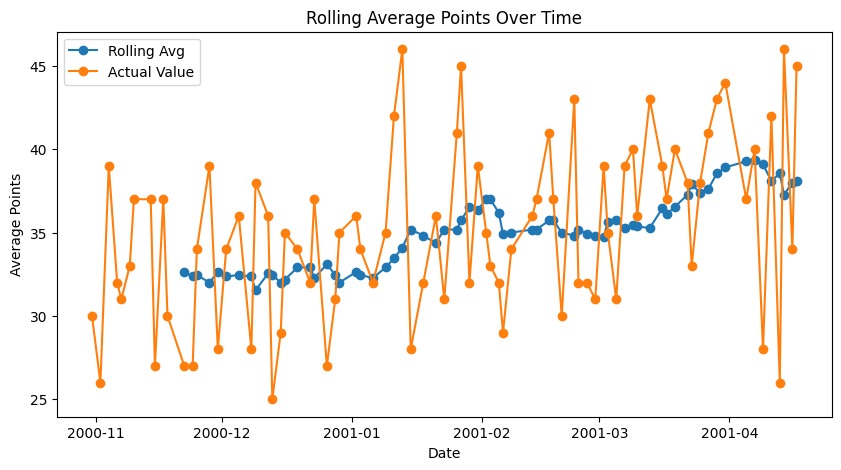

4.945636247321063

In [112]:
min_error = None
best_window = 0
team = 0
feature = 'FGM'
season = 2000

for i in range(1, 20) :
    rmse = rollingAvg(team, feature, i, season, False)
    if min_error is None or rmse < min_error:
        min_error = rmse
        best_window = i

print("Best Window:", best_window)
rollingAvg(team, feature, best_window, season)

The code above finds that the best window for the `FGM` variable is 11. It then visualizes the predictions agains the actual values and provides the RMSE of them. 

Next, we look at a heatmap showing the win percentages between teams to see how teams perform.

In [113]:
def calculateWinMatrix(start_season = all_stats_cleaned['SEASON_YEAR'].min(), end_season = all_stats_cleaned['SEASON_YEAR'].max()) :
    """
    This function takes a range of seasons and calculates the win percentages of the a team against all other teams for all games
    occuring within the provided season. Each row represents the win percentages a team.

    Inputs:
    start_season: first season to look at (default first recorded season)
    end_season: last season to consider (default most recent season)

    Output: Numpy matrix containing win percentages for team by row.
    """
    
    num_teams = len(team_id_to_abb)
    np_win_matrix = np.zeros((num_teams, num_teams))
    for team_one in range(num_teams):
        for team_two, team_two_abb in team_id_to_abb.items() :
            if team_one == team_two : continue
            games = wins = 0
            for x in team_two_abb :
                matches = all_stats_cleaned[(all_stats_cleaned['TEAM_ID'] == team_one) & (all_stats_cleaned['OPPONENT'] == x) & (all_stats_cleaned['SEASON_YEAR'].between(start_season, end_season)) ]
                games += len(matches)
                wins += len(matches[matches['WIN'] == 1])
        
            np_win_matrix[team_one][team_two] = wins / games
    return np_win_matrix


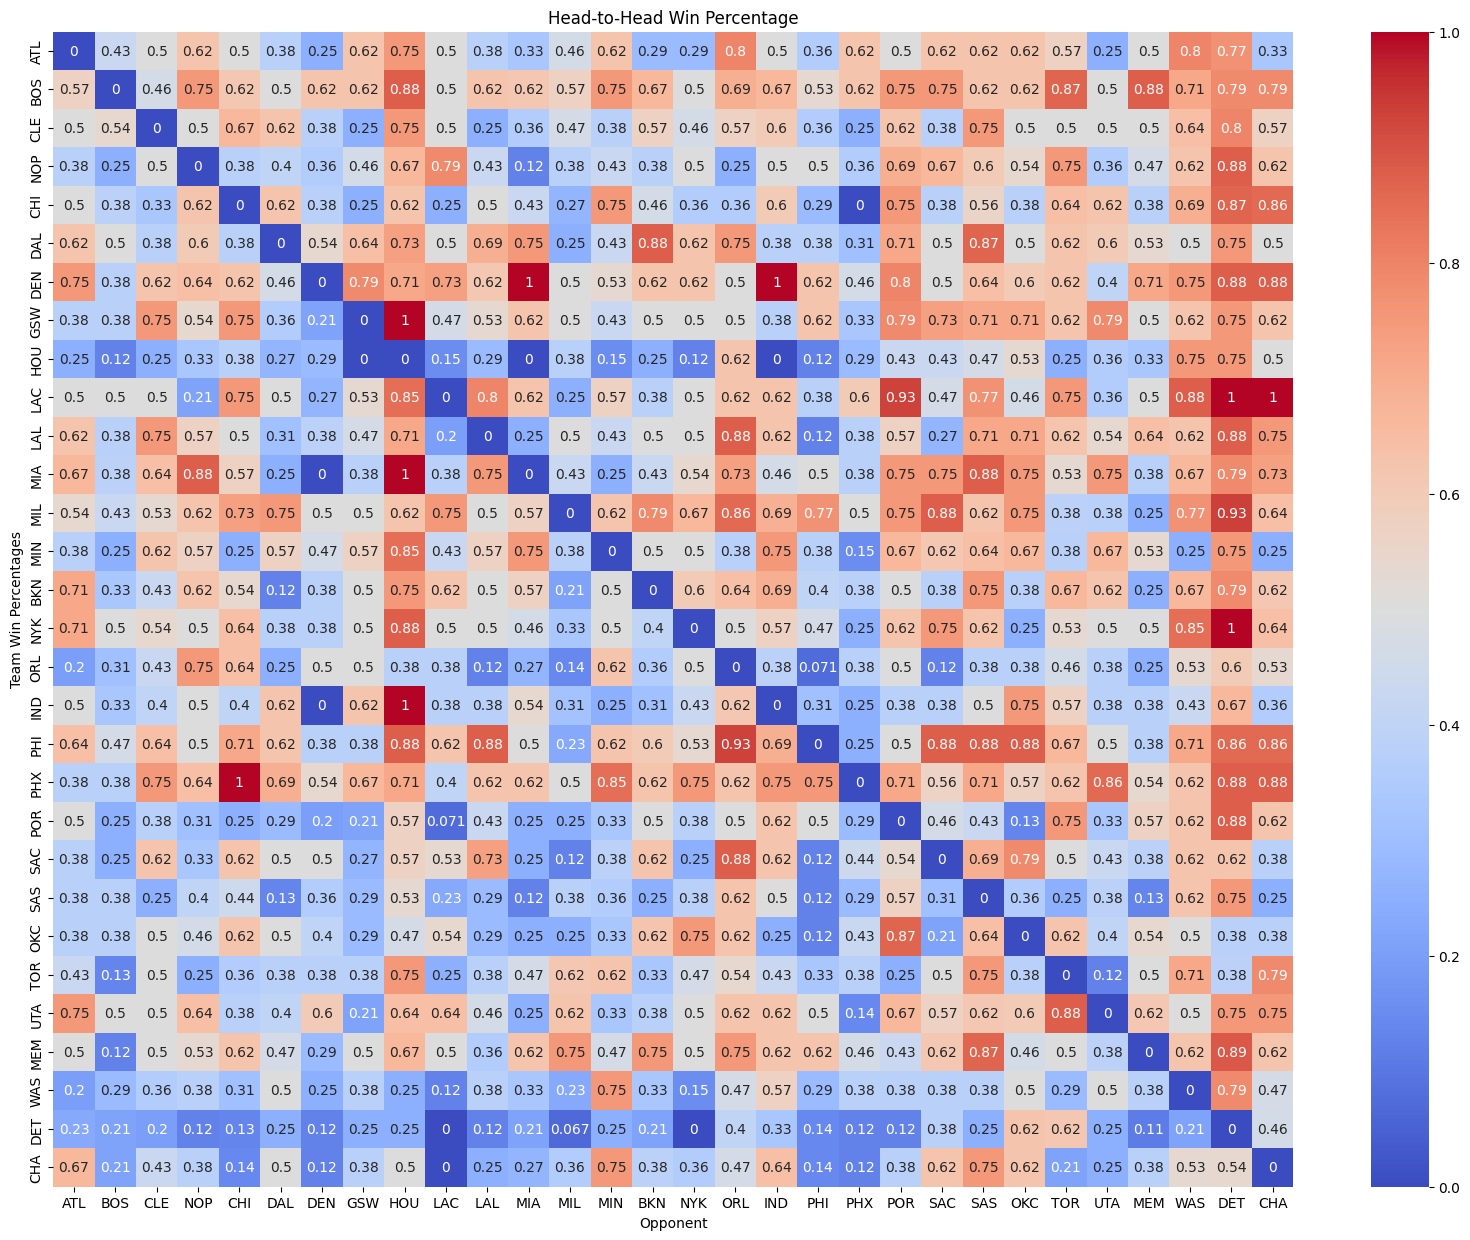

In [114]:
np_win_matrix = calculateWinMatrix(2020, 2025)
teams = [team_id_to_abb[i][-1] for i in team_id_to_abb]
plt.figure(figsize =(20,15))
sns.heatmap(np_win_matrix, annot=True, cmap="coolwarm", xticklabels=teams, yticklabels=teams) 
plt.xlabel("Opponent")
plt.ylabel("Team Win Percentages")
plt.title("Head-to-Head Win Percentage")
plt.show()

Looking at the heatmap above, we can see that certain teams perform far better and worse than others. For example, DET loses more games than wins against nearly every team in the range from 2020 to 2025. The same goes for Washington. However, Washington seems to fare especially well against MIN despite MIN generally having win percentages above 50%. This tells us that Washington may perform especially well against MIN and increase their probability of winning despite generally losing their games. 

Another important factor is home-court advantage (i.e. increased chance of winning due to playing at home). We want to observe how this affects teams. Since teams typically play half their games at home and half away (playing each team twice during a season, once at home at once away), we can forgo calculating home wins / total home games and away wins / total away games and instead just look at how many wins were home. 

In [115]:
def homeWins(team_id) :
    """
    This function takes a team ID and calculates the percentages of wins that are at home each season. 
    Then, we graph the values on a bar graph.

    Inputs:
    team_id: team ID, required
    """
    start = all_stats_cleaned['SEASON_YEAR'].min()
    end = all_stats_cleaned['SEASON_YEAR'].max()

    years = list(range(start, end+1))
    win_percentages = []
    games = all_stats_cleaned[all_stats_cleaned['TEAM_ID'] == team_id]

    for i in years :
        games_in_season = games[games['SEASON_YEAR'] == i]
        wins_in_season = games_in_season[games_in_season['WIN'] == 1]
        home_wins = wins_in_season[wins_in_season['HOME'] == 1]
        if len(wins_in_season) == 0 : 
            win_percentages.append(0)
        else :
            win_percentages.append(len(home_wins) / len(wins_in_season))

    team_abb = team_id_to_abb[team_id][-1]
    plt.bar(years, win_percentages)
    plt.xlabel('Year')
    plt.ylabel('Win Percentages At Home')
    plt.title(f'Win Percentages at Home for {team_abb} over the Years')
    plt.show()

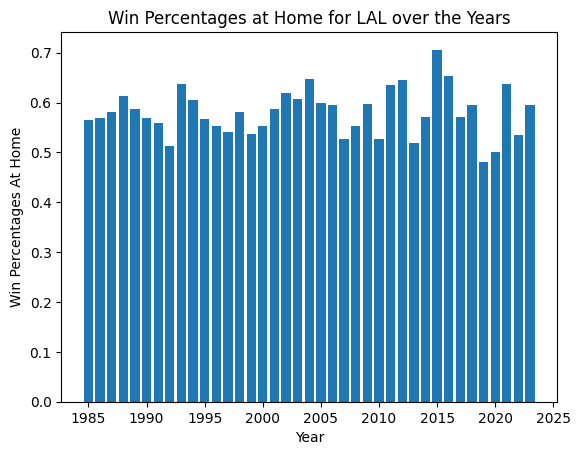

In [116]:
homeWins(10)

The above bargraph shows us that for the Los Angeles Lakers (LAL), the game being at home results in a slightly higher probability of winning. Looking at more teams, we will see that this trend continues, although perhaps not as strong as some may think. This indicates the model may find whether the game is home or away to be a significant factor. 

We also want to see how values compare in games they won or lost. We can do that by graphing the averages over a season for games a specific team lost and won as follows. 

In [1]:
def winLossAverages(team_id, feature) :
    """
    This function takes a team ID and a feature and calculates the average value of that feature 
    for each season separated into games won or lost. This allows us to see how a value could be 
    used to predict if a team will win or not.
    """
    start = all_stats_cleaned['SEASON_YEAR'].min()
    end = all_stats_cleaned['SEASON_YEAR'].max()

    years = list(range(start, end+1))
    avg_for_wins = []
    avg_for_losses = []

    for y in years :
        games = all_stats_cleaned[all_stats_cleaned['SEASON_YEAR'] == y]
        wins = games[games['WIN'] == 1]
        losses = games[games['WIN'] == 0]

        avg_for_wins.append(wins[feature].mean())
        avg_for_losses.append(losses[feature].mean())

    plt.figure(figsize = (10, 5))
    plt.plot(years, avg_for_wins, linestyle = '-', label = "Games Won")
    plt.plot(years, avg_for_losses, linestyle = '-', label = "Games Lost")
    plt.xlabel("Seasons")
    plt.ylabel(f"Average {feature}")
    plt.title(f"Comparing Averages of {feature} For Games Won or Lost by {team_id_to_abb[team_id][-1]}")
    plt.legend()
    plt.show()

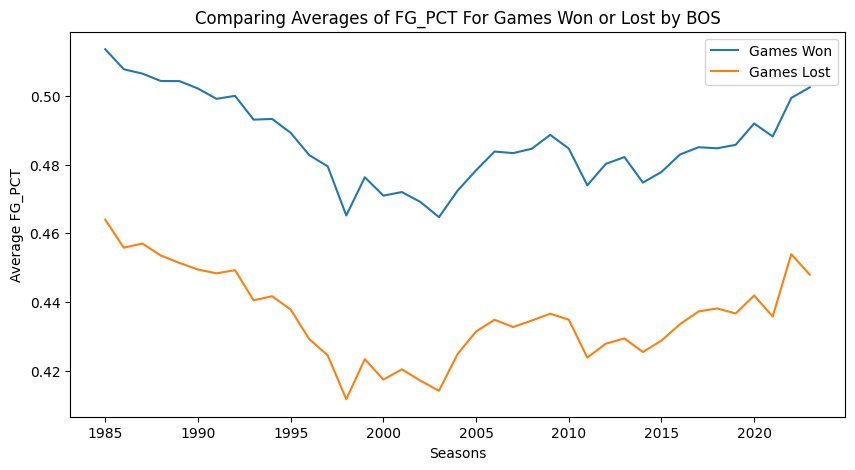

In [118]:
winLossAverages(1, 'FG_PCT')

Above we can see that field goal percentage is always significantly higher when games are won. Thus, when we expect a team to have a higher field goal percentage, they have a higher likelihood of winning. 

## Feature Selection / Feature Importance 

In [45]:
all_stats_cleaned.columns

Index(['TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_DATE', 'HOME',
       'OPPONENT_ID', 'WIN', 'OPPONENT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'SEASON_YEAR'],
      dtype='object')